In [1]:
from dotenv import load_dotenv
from helpers.utils import Utils

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.patches import Rectangle
from ipywidgets import interactive, VBox, Layout, HBox, IntSlider, FloatSlider, IntRangeSlider

from models.peer import Peer
from models.data_model import DataModel

%config InlineBackend.figure_format = 'retina'

### Set default parameters for status quo graphs

In [2]:
use_snapshot = True
default_snapshot = "2024_03_28"

min_version = "2.0.7"
budget_dollar = 7500
token_price = 0.15
min_stake_wxhopr = 10e3
thrs_stake_wxhopr = 75e3
transformation_slope = 1
transformation_flattening_factor = 1.4

In [3]:
class StakeModel(DataModel):
    def __init__(self, use_snapshot: bool):
        self.peers = []
        self.topology = []
        self.safe = []
        super().__init__(use_snapshot)
    
    async def get_dynamic_data(self):
        self.safes = await Utils.getSafesData()
        self.topology = await Utils.getTopologyData()
        self.peers = await Utils.getPeers()


    def load_snapshot(self, folder: str):
        self.peers, self.safes, self.topology = Utils.loadSnapshot(folder, "peers", "safes", "topology")
 
    def dump_snapshot(self, folder: str):
        Utils.dumpSnapshot(peers=self.peers, safes=self.safes, topology=self.topology)

    def plot_static(self, ax: plt.Axes, peers: list[Peer], bin: list[int], limits: list[int], token_price: float, watermark: str):
        stakes = [peer.split_stake for peer in peers]
        rewards = [peer.rewards for peer in peers]

        apr = sum(rewards) / sum(stakes) * 12 if sum(stakes) > 0 else 0
    
        texts = [
            f"Stakes: {sum(stakes):_.0f} wxHOPR",
            f"Rewards: {sum(rewards):_.0f} wxHOPR -> Budget: {sum(rewards)*token_price:_.0f} $",
            f"APR (avg.): {apr:.2%}",
            f"Peers: {len(peers)}"
        ]

        # plot
        counts, _, bars = ax.hist(stakes, bins=bin, facecolor="#000050", edgecolor='black', linewidth=1.2, rwidth=.85)
        max_height = max(round(counts.max() / 20 + .5) * 20, 1)
        areas = [
            (((0, 0), limits[0], max_height), "#ff0000"),
            (((limits[0], 0), limits[1]-limits[0], max_height), "#ffffa0")
        ]

        # settings
        ax.bar_label(bars)
        ax.set_xlim(bin[0], bin[-1])
        ax.set_ylim(0, max_height)
        ax.set_xlabel("Stake (wxHOPR)")
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))

        [ax.add_patch(Rectangle(*loc, color=color, alpha=.4, zorder=0)) for loc, color in areas]

        for idx, text in enumerate(texts):
            test_item = ax.text(.95, .95-idx*.1, text, transform=ax.transAxes, ha='right', va='top')
            test_item.set_bbox(dict(facecolor='#b4f0ff', alpha=.5, edgecolor='white'))

        ax.text(0.5, 0.5, watermark, transform=ax.transAxes,
            fontsize=40, color='gray', alpha=0.5,
            ha='center', va='center', rotation=30)

    def plot_static_multi(self, bin_count: int, limits: list[int], slope: float, flattening_factor: float, token_price: float, target_apr: float, random_extra_stake_range: list[int], num_extra_nodes: int, extra_node_apr_factor: float, overlay: str = ""):
        eligibles = Utils.getEligiblesPeers(self.topology, self.peers, self.safes, min_version)
        splited_peers = [[], []]

        ################## ADD EXTRA NODES ################################
        for _ in range(num_extra_nodes):
            eligibles.append(Peer.extra(random_extra_stake_range))

        total_stake = sum(peer.split_stake for peer in eligibles if peer.split_stake > limits[0])
        budget_dollars = target_apr * total_stake / 12 / 100 * token_price

        eligibles = Utils.getRewardProbability(eligibles, token_price, budget_dollars, limits, slope, flattening_factor)

        # probability adjustment
        for peer in eligibles:
            if "extra_address" not in peer.address.address:
                continue
            peer.reward_probability *= extra_node_apr_factor

        total_probability = sum(peer.reward_probability for peer in eligibles)

        # normalize the probability
        for peer in eligibles:
            peer.reward_probability /= total_probability
        ###############################################################################
        
        # split the peers betweenn two groups
        for peer in eligibles:
            splited_peers[peer.split_stake >= limits[1]].append(peer)
        
        # prepare bins for both groups
        bins = [
            Utils.binsFromRange(0, limits[1], bin_count),
            Utils.binsFromRange(limits[1], 800e3, bin_count)
        ]

        _, axes = plt.subplots(1, len(splited_peers)+1, figsize=(7*(len(splited_peers)+1), 4.5), sharex=False, sharey=False)
        axes = axes.flatten() if not isinstance(axes, plt.Axes) else [axes]

        for idx, (ax, split, bin) in enumerate(zip(axes[1:], splited_peers, bins)):
            self.plot_static(ax, split, bin, limits, token_price, overlay)

        # Add extra text on the righthand side
        texts = [
            f"Total stake: {total_stake:_.0f} wxHOPR",
            f"Total budget: {budget_dollars:_.0f} $",
            f"Avg. APR: {target_apr:.2f}%",
            f"Total peers: {len(eligibles)}",
        ]
        for idx, text in enumerate(texts):
            text_item = axes[0].text(0.95, .45-idx*.1, text, transform=axes[0].transAxes, ha='right', va='top')
            text_item.set_bbox(dict(facecolor='#b4f0ff', alpha=.5, edgecolor='white'))

        x_range = list(range(int(limits[0]), int(800e3), int(2.5e3)))
        tf_stake = [eligibles[0].economic_model.transformed_stake(stake) for stake in x_range ]
        x_range = [val/1e3 for val in x_range]
        tf_stake = [val/1e3 for val in tf_stake]

        axes[0].plot(x_range, tf_stake, "#000050")
        axes[0].set_xlabel("Stake (k wxHOPR)")
        axes[0].set_ylabel("Transformed stake (k wxHOPR)")

        axes[0].text(0.5, 0.5, overlay, transform=axes[0].transAxes,
            fontsize=40, color='gray', alpha=0.5,
            ha='center', va='center', rotation=30)

        # Finalize the plot
        _ = axes[1].set_ylabel("Number of peers")
        axes[-1].text(1, -0.15, "Budgets are calculated /month", transform=axes[-1].transAxes, ha='right', va='top', style="italic")
        # plt.subplots_adjust(wspace=0.1)

    def plot_interactive(self):
        style = {'description_width': 'initial', 'value_width': 'initial'}

        # histogram controls
        bin_slider = IntSlider(min=5, max=30, step=1, value=15, description="Bins count", style=style)

        # distribution controls
        limits_slider = IntRangeSlider(min=0, max=500e3, step=5e3, description="Eligibility thres.", value=[min_stake_wxhopr, thrs_stake_wxhopr], style=style, layout={"width": "600px"})
        slope_slider = FloatSlider(min=0.1, max=2.0, step=0.1, value=transformation_slope, description="Slope", style=style)
        flattening_factor_slider = FloatSlider(min=1, max=3, step=0.1, value=transformation_flattening_factor, description="Flattening factor", style=style)

        # prices
        apr_slider = FloatSlider(min=0.1, max=20.0, step=0.1, value=15, description="Target APR", style=style)
        token_price_slider = FloatSlider(min=0.01, max=0.20, step=0.001, value=token_price, description="Token price ($)",readout_format='.3f', style=style)

        # extra investors sliders
        random_extra_stake_slider = IntRangeSlider(min=0, max=800e3, step=25e3, description="Random stake", value=[250e3, 350e3], style=style, layout={"width": "600px"})
        num_extra_nodes_slider = IntSlider(min=0, max=300, step=1, value=0, description="Extra nodes", style=style)
        extra_node_apr_factor_slider = FloatSlider(min=1, max=10.0, step=0.1, value=1, description="Extra APR boost", style=style)

        # MAIN PLOTS WINDOW
        widgets = interactive(self.plot_static_multi, limits=limits_slider, slope=slope_slider, flattening_factor=flattening_factor_slider, bin_count=bin_slider, token_price=token_price_slider, target_apr=apr_slider, random_extra_stake_range=random_extra_stake_slider, num_extra_nodes=num_extra_nodes_slider,extra_node_apr_factor=extra_node_apr_factor_slider, overlay="Simulation")

        distribution_controls = HBox(widgets.children[1:4], layout = Layout(flex_flow='row wrap'))
        prices_controls = HBox(widgets.children[4:6], layout = Layout(flex_flow='row wrap'))
        extra_investor_controls = HBox(widgets.children[6:9], layout = Layout(flex_flow='row wrap'))
        hist_controls = widgets.children[0]

        self.plot_static_multi(limits=[min_stake_wxhopr, thrs_stake_wxhopr], slope=transformation_slope, flattening_factor=transformation_flattening_factor, bin_count=15,token_price=token_price, target_apr=15.0, random_extra_stake_range=[0], num_extra_nodes=0, extra_node_apr_factor=1, overlay="Status quo")

        # self.plot_static_multi(15, [min_stake_wxhopr, thrs_stake_wxhopr], "Safes\nStatus quo")

        display(VBox([distribution_controls, prices_controls, extra_investor_controls, hist_controls]))
        display(widgets.children[-1])

### Get data (snapshot or current data from the network)


In [4]:
model = StakeModel(use_snapshot or not load_dotenv())

await model.get_data(default_snapshot)

print(f"Subgraph size: {len(model.safes)}")
print(f"Topology size: {len(model.topology)}" )
print(f"Number of peers: {len(model.peers)}")

Subgraph size: 785
Topology size: 481
Number of peers: 394


### Plot the interactive simulation and status quo graphs

Output()

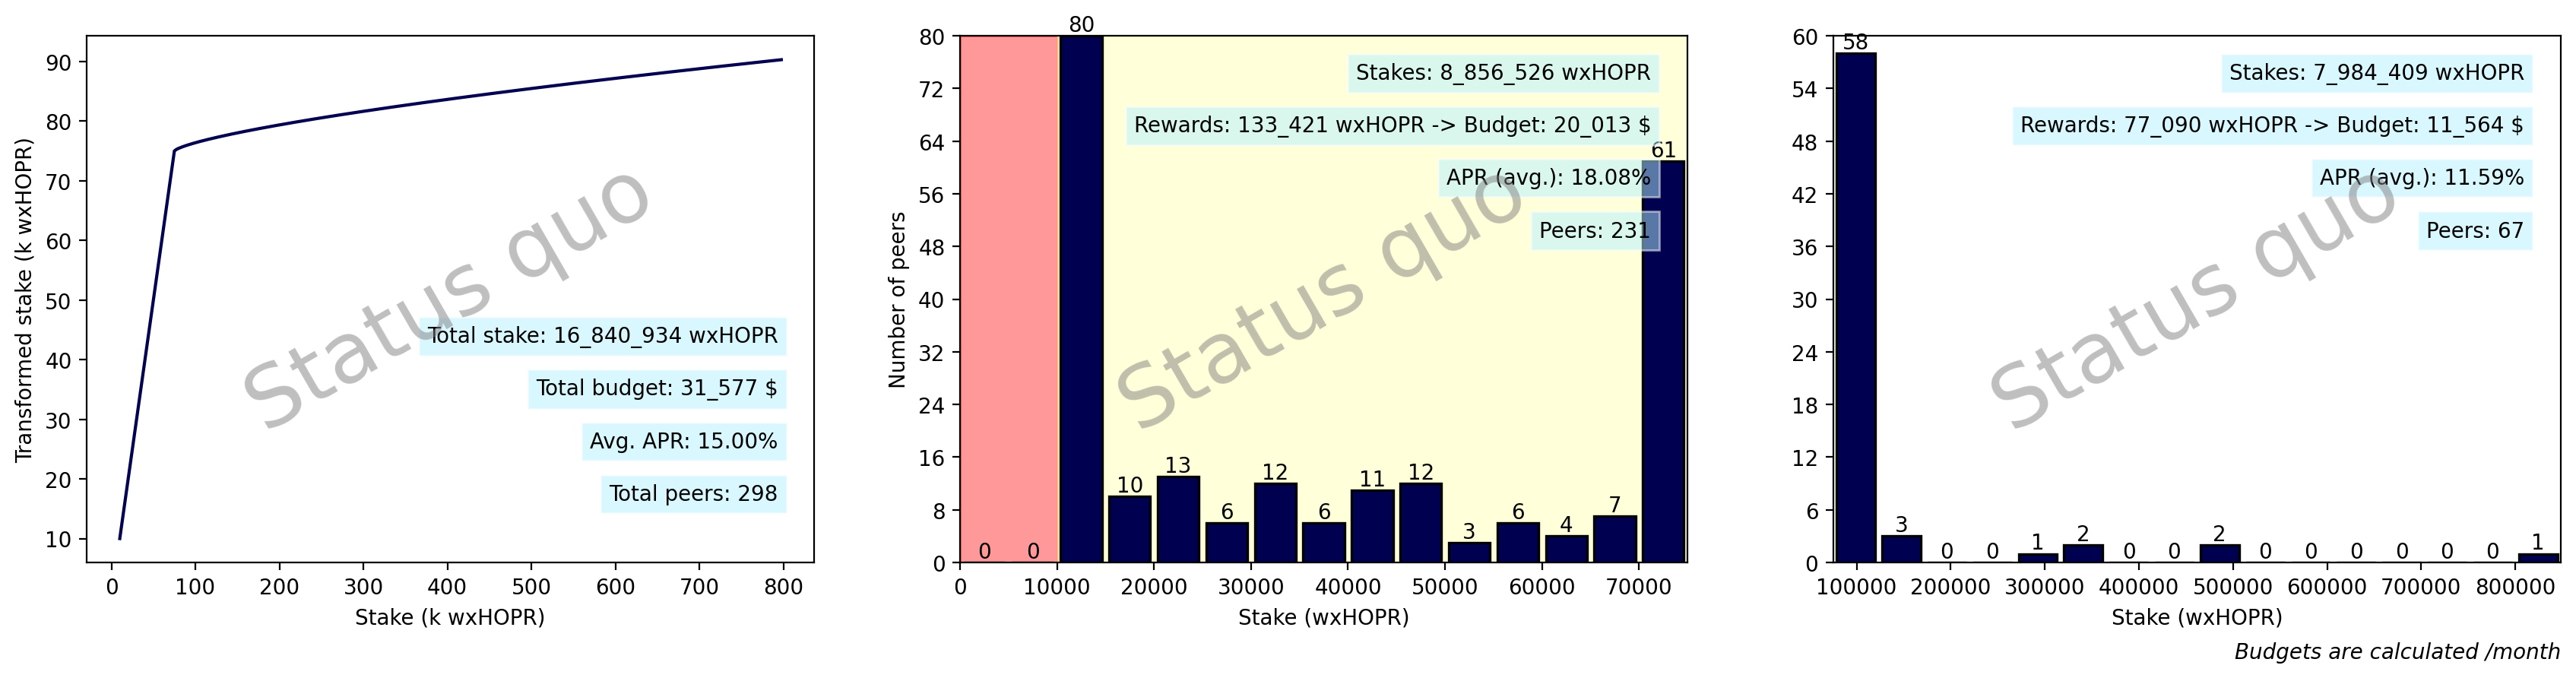

In [5]:
model.plot_interactive()

### Bringing RPCh in the picture 

In [7]:
packets_outliars = 0.001
hopr_packet_size=400

rpch_requests, rpch_responses = Utils.loadSnapshot(default_snapshot, "rpch_requests_60d", "rpch_responses_60d")
rpch_requests.sort()
rpch_responses.sort()

rpch_requests = rpch_requests[0:int(len(rpch_requests) * (1 - packets_outliars))]
rpch_responses = rpch_responses[0:int(len(rpch_responses) * (1 - packets_outliars))]

req_resp_avg_size = sum(rpch_requests)/len(rpch_requests) + sum(rpch_responses)/len(rpch_responses)
packets_per_comm = req_resp_avg_size/hopr_packet_size
requests_per_day = len(rpch_requests)/60
packets_per_day = requests_per_day * packets_per_comm

print(f"Average RPCh request and response size: {req_resp_avg_size:.2f} bytes")
print(f"Average packets per request/response: {packets_per_comm:.2f}")
print(f"Packets per day: {packets_per_day:_.2f} -> {requests_per_day:_.2f} requests per day")


Average RPCh request and response size: 1723.69 bytes
Average packets per request/response: 4.31
Packets per day: 177_943.46 -> 41_293.57 requests per day


In [8]:
budget = 10526
token_price = 0.10
ticket_price = 0.01
relay_success_rate = 0.985

In [9]:
ct_packets = budget / 30 / token_price / ticket_price - packets_per_day

print("Current throughput shouldn't change")
print("-"*100)
print("rpch_packets + ct_packets = budget / token_price / ticket_price")
print( "\t-> ct_packets  = budget / token_price / ticket_price - rpch_packets")
print(f"\t               = {budget} / 30 / {token_price} / {ticket_price} - {packets_per_day:_.2f}")
print(f"\t               = {ct_packets:_.2f} messages / day")
print("-"*100)

Current throughput shouldn't change
----------------------------------------------------------------------------------------------------
rpch_packets + ct_packets = budget / token_price / ticket_price
	-> ct_packets  = budget / token_price / ticket_price - rpch_packets
	               = 10526 / 30 / 0.1 / 0.01 - 177_943.46
	               = 172_923.20 messages / day
----------------------------------------------------------------------------------------------------


In [10]:
rpch_request_price = (ct_packets/ packets_per_day + 1) * ticket_price * packets_per_comm
rpch_plan = round((rpch_request_price*token_price * 2000)/5 + 0.5) * 5

print("RPCh margin should be greater than the cost of CT")
print("-"*100)
print("rpch_revenue - rpch_cost > ct_cost")
print("\t-> rpch_packets / packets_per_request * request_price - rpch_packets * ticket_price > ct_packets * ticket_price")
print("\t-> rpch_packets * (request_price / packets_per_request / ticket_price - 1) > ct_packets")
print("\t-> request_price > (ct_packets / rpch_packets + 1) * ticket_price * packets_per_request")
print(f"\t                 > ({ct_packets:_.2f} / {packets_per_day:_.2f} + 1) * {ticket_price} * {packets_per_comm:_.2f}")
print(f"\t                 > {rpch_request_price:_.4f} wxHOPR")
print(f"\t                 > {rpch_request_price*token_price:_.4f} $")
print("-"*100, end="\n\n")

print(f"RPCh plan should cost at least: {rpch_plan:_.2f}$/2000req.")

RPCh margin should be greater than the cost of CT
----------------------------------------------------------------------------------------------------
rpch_revenue - rpch_cost > ct_cost
	-> rpch_packets / packets_per_request * request_price - rpch_packets * ticket_price > ct_packets * ticket_price
	-> rpch_packets * (request_price / packets_per_request / ticket_price - 1) > ct_packets
	-> request_price > (ct_packets / rpch_packets + 1) * ticket_price * packets_per_request
	                 > (172_923.20 / 177_943.46 + 1) * 0.01 * 4.31
	                 > 0.0850 wxHOPR
	                 > 0.0085 $
----------------------------------------------------------------------------------------------------

RPCh plan should cost at least: 20.00$/2000req.
